In [1]:
import duckdb
import matplotlib.pyplot as plt
from matplotlib.scale import LogScale
from matplotlib.ticker import FuncFormatter
import matplotlib.patheffects as PathEffects
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import copy

import seaborn as sns
import seaborn.objects as so
from seaborn import axes_style
from seaborn import plotting_context

In [2]:
deep = sns.color_palette('deep')
deep

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [3]:
palette = [deep[1], deep[0], deep[2], deep[4], deep[3]]

In [4]:
# notes:
# https://matplotlib.org/stable/users/explain/customizing.html

In [5]:
con = duckdb.connect()

con.execute("""
CREATE MACRO pretty_system(s) AS
CASE s
WHEN 'duckdb_without_cm' THEN 'DuckDB no CM'
WHEN 'duckdb_with_cm' THEN 'DuckDB'
WHEN 'hyper' THEN 'HyPer'
WHEN 'postgresql' THEN 'PostgreSQL'
WHEN 'umbra' THEN 'Umbra'
ELSE s END
""")

systems = ["duckdb_without_cm", "duckdb_with_cm", "postgresql", "hyper", "umbra"]

for system in sorted(systems):
    con.execute(f"""ATTACH IF NOT EXISTS '../results/{system}.duckdb' AS {system} (READ_ONLY TRUE);""")
con.execute(f"""CREATE VIEW IF NOT EXISTS all_results AS ({' UNION ALL '.join([f"SELECT '{system}' AS system, * FROM {system}.main.results" for system in systems])})""")
results_int_df = con.execute("""
SELECT * REPLACE (median(t) AS t)
FROM all_results
GROUP BY ALL
ORDER BY ALL""").fetchdf()
results_df = con.execute("""SELECT * REPLACE(sf::VARCHAR as sf) FROM results_int_df""").fetchdf()
results_df.head()

,system,sf,q,thin,t
0,duckdb_with_cm,1,1,False,0.064084
1,duckdb_with_cm,1,1,True,0.032699
2,duckdb_with_cm,1,2,False,0.081798
3,duckdb_with_cm,1,2,True,0.040872
4,duckdb_with_cm,1,3,False,0.123966


In [6]:
my_style = {
    'figure.facecolor': 'white',
    'axes.labelcolor': '.15',
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.color': '.15',
    'ytick.color': '.15',
    'axes.axisbelow': True,
    'grid.linestyle': '-',
    'text.color': '.0',
    'font.family': ['sans-serif'],
    'font.sans-serif': [
        'Arial',
        'DejaVu Sans',
        'Liberation Sans',
        'Bitstream Vera Sans',
        'sans-serif'
    ],
    'lines.solid_capstyle': 'round',
    'patch.edgecolor': 'w',
    'patch.force_edgecolor': True,
    'image.cmap': 'rocket',
    'xtick.top': False,
    'ytick.right': False,
    'axes.grid': True,
    'axes.facecolor': 'white',
    'axes.edgecolor': '.0',
    'grid.color': '.75',
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.right': True,
    'axes.spines.top': True,
    'xtick.bottom': False,
    'ytick.left': False
}

In [7]:
@FuncFormatter
def my_formatter(x, pos):
    if x >= 1:
        return "{:.0f}".format(x)
    return "{:.1g}".format(x)

In [8]:
def dead(ax, from_sf, color, letter):
    x = int(np.log2(from_sf))
    x_max = int(np.log2(256)) + 1
    rect = patches.Rectangle((x, 0.000001), x_max - x, 2000, linewidth=1, edgecolor='black', facecolor='black')
    ax.add_patch(rect)

    for i in range(x + 1, x_max):
        txt = ax.text(i, 1500, letter, horizontalalignment='center', verticalalignment='top', color=color, fontsize=18)
        txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

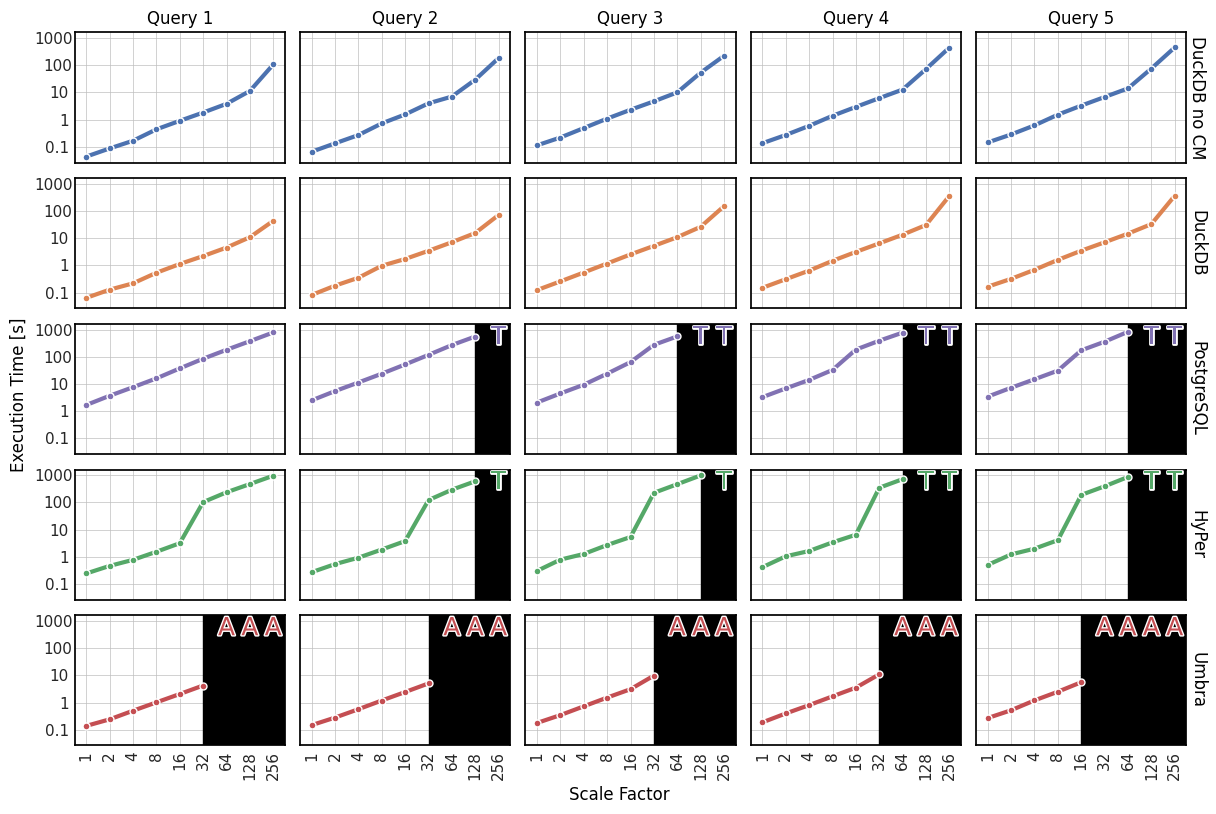

In [17]:
f = plt.figure(figsize=(12, 8), dpi=100)

fontsize = 12
tickfontsize = 11

modified_style = copy.copy(my_style)
modified_style['xtick.major.bottom'] = True
modified_style['axes.labelsize'] = fontsize
modified_style['ytick.labelsize'] = tickfontsize
modified_style['grid.linewidth'] = 0.5
# modified_style['ytick.major.left'] = False

systems_ordered = ["DuckDB no CM", "DuckDB", "PostgreSQL", "HyPer", "Umbra"]

p = (
    so.Plot(
        con.execute(f"""
            SELECT pretty_system(system) as "System",
                   sf AS "Scale Factor",
                   CASE WHEN thin THEN 'Thin' ELSE 'Wide' END as "Thin",
                   t AS "Execution Time [s]", q as "Query"
            FROM results_df
            WHERE t > 0
            and not thin
        """).fetchdf(),
        x='Scale Factor', y='Execution Time [s]', color='System'
    )
    .scale(y=so.Continuous(trans='log10').label(my_formatter).tick(minor=0), color=palette)
    .facet(col='Query', row='System', order={"col": [1, 2, 3, 4, 5], "row": systems_ordered})
    .add(so.Line(linewidth=3, marker='o', pointsize=5, edgecolor='w'))
    .share(x=True, y=True)
    .theme(modified_style)
    .on(f)
    .plot()
)

postgresql_row_start = 10
postgresql_color = sns.color_palette('deep')[4]
# dead(f.axes[postgresql_row_start], 128, postgresql_color, 'T')
dead(f.axes[postgresql_row_start + 1], 128, postgresql_color, 'T')
dead(f.axes[postgresql_row_start + 2], 64, postgresql_color, 'T')
dead(f.axes[postgresql_row_start + 3], 64, postgresql_color, 'T')
dead(f.axes[postgresql_row_start + 4], 64, postgresql_color, 'T')

hyper_row_start = 15
hyper_color = sns.color_palette('deep')[2]
# dead(f.axes[hyper_row_start], 128, hyper_color, 'T')
dead(f.axes[hyper_row_start + 1], 128, hyper_color, 'T')
dead(f.axes[hyper_row_start + 2], 128, hyper_color, 'T')
dead(f.axes[hyper_row_start + 3], 64, hyper_color, 'T')
dead(f.axes[hyper_row_start + 4], 64, hyper_color, 'T')

umbra_row_start = 20
umbra_color = hyper_color = sns.color_palette('deep')[3]
dead(f.axes[umbra_row_start], 32, umbra_color, 'A')
dead(f.axes[umbra_row_start + 1], 32, umbra_color, 'A')
dead(f.axes[umbra_row_start + 2], 32, umbra_color, 'A')
dead(f.axes[umbra_row_start + 3], 32, umbra_color, 'A')
dead(f.axes[umbra_row_start + 4], 16, umbra_color, 'A')

xticks = f.axes[-1].get_xticks()
xticklabels = f.axes[-1].get_xticklabels() 
yticks = [0.1, 1, 10, 100, 1000]
ylim = (f.axes[0].get_ylim()[0], 1500)

for ax in f.axes:
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, rotation=90, fontsize=tickfontsize)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks)
    # ax.set_ylim(ylim[0], ylim[1])
    ax.grid(True, 'both')
    ax.tick_params(axis='both', which='major', pad=-2)

f.text(0.5, 0, 'Scale Factor', horizontalalignment='center', verticalalignment='center', fontsize=fontsize)
f.text(0, 0.5, 'Execution Time [s]', rotation=90, horizontalalignment='center', verticalalignment='center', fontsize=fontsize)

f.subplots_adjust(hspace=0, wspace=0)

queries = int(len(f.axes) / len(systems_ordered))
for i in range(queries):
    ax = f.axes[i]
    ax.set_title(f'Query {i + 1}', fontsize=fontsize)

for i in range(len(systems_ordered)):
    ax = f.axes[(i + 1) * queries - 1]
    ylim = ax.get_ylim()
    y = 10**((np.log10(ylim[0]) + np.log10(ylim[1])) / 2)
    ax.text(ax.get_xlim()[1] + 0.85, y, systems_ordered[i], rotation=-90, horizontalalignment='right', verticalalignment='center', fontsize=fontsize)

legend = f.legends.pop(0)
# f.legend(legend.legend_handles, [t.get_text() for t in legend.texts], loc='upper center', bbox_to_anchor=(0.5, 1.04), framealpha=1, fontsize=15, ncol=3)

f.tight_layout()
f.savefig(f"../figures/faceted.eps", bbox_inches='tight')
f.savefig(f"../figures/faceted.pdf", bbox_inches='tight')
# plt.close(f)